<a href="https://colab.research.google.com/github/MinsooKwak/RAG/blob/main/test/search/vectordb_indexing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 인덱스 생성 과정
- 데이터 전처리 후 벡터 변환
- 클러스터링(k-means clustering)
  - 유의미한 군집 (partition=clustering=군집)
- 인덱스 구축
  - IVF, Product Quantization이 많이 쓰임. </br>두개 또는 Flat Index까지 포함 3개 조합해 사용 많이 함
    - Flat Index : Brute-force search
      - 가장 높은 정확도
      - 많은 계산량
    - IVF (Inverted File Index)
      - 속도 정확도 좋음
      - 중간~ 대규모 데이터셋 적합
    - Product Quantilization
      - 매우 큰 데이터셋에 적합
    - HNSW (Hierarchical Navigable Small World)
      - 그래프 기반 인덱스
      - 고차원 데이터에 효율적
- 검색
  - 정확한 검색 (키워드 검색)
  - 근사 검색 (유사도 검색)
- 후처리 : (대표적 : Reranking)
  - 98% 정확도 원하나 90%-91% 나올 때

**IVF**

- original vector (파란색)
- centroid (partition별 vector들의 중앙값)

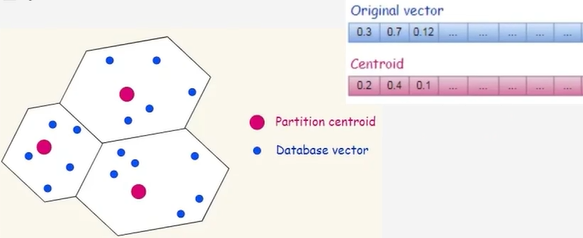

- nprobs
  - 질문이 들어올 때 몇 개의 파티션 이용해 대답
  - 참고 (https://thedataquarry.com/posts/vector-db-3/)

In [1]:
#!pip install faiss-cpu  # gpu
#!pip install langchain
#!pip install openai
#!pip install -U langchain-community
#!pip install tiktoken

In [2]:
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS

In [3]:
import numpy as np
import faiss

In [4]:
#!pip install pypdf

In [5]:
# PDF 가져올 때
from langchain.document_loaders import PyPDFLoader

# PDF 가져오기
loaders = [
    PyPDFLoader("2306.05685v4.pdf")
]

docs = []
for loader in loaders:
  docs.extend(loader.load())

In [6]:
# API키
import os
from config import OPEN_AI_API_KEY
os.environ["OPENAI_API_KEY"] = OPEN_AI_API_KEY

In [7]:
# CharacterTextSplitter 사용

c_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 1000,
    chunk_overlap = 200,
    length_function = len
)

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200,
    separators = ["\n\n","\n"]
)

# 문장 청킹
chunks = r_splitter.split_text(docs[0].page_content)
print(len(chunks))
print(chunks)
print("")

# 문서 청킹
split_docs = r_splitter.split_documents(docs)
print(f'문서 개수 : {len(split_docs)}')
print(split_docs[0])
print('-'*30)
print(split_docs[1])
print('-'*30)
print(split_docs[2])
print('-'*30)
print(split_docs[3])
print('-'*30)
print(split_docs[4])

4
['Judging LLM-as-a-Judge\nwith MT-Bench and Chatbot Arena\nLianmin Zheng1∗Wei-Lin Chiang1∗Ying Sheng4∗Siyuan Zhuang1\nZhanghao Wu1Yonghao Zhuang3Zi Lin2Zhuohan Li1Dacheng Li13\nEric P. Xing35Hao Zhang12Joseph E. Gonzalez1Ion Stoica1\n1UC Berkeley2UC San Diego3Carnegie Mellon University4Stanford5MBZUAI\nAbstract\nEvaluating large language model (LLM) based chat assistants is challenging due to\ntheir broad capabilities and the inadequacy of existing benchmarks in measuring\nhuman preferences. To address this, we explore using strong LLMs as judges to\nevaluate these models on more open-ended questions. We examine the usage and\nlimitations of LLM-as-a-judge, including position, verbosity, and self-enhancement\nbiases, as well as limited reasoning ability, and propose solutions to mitigate some\nof them. We then verify the agreement between LLM judges and human preferences\nby introducing two benchmarks: MT-bench, a multi-turn question set; and Chatbot', 'of them. We then verify the ag

In [8]:
# openai에서 제공하는 embedding 모델 활용
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", api_key=OPEN_AI_API_KEY)

# split_docs에서 각 문서의 텍스트를 추출하고, 임베딩을 생성
texts = [doc.page_content for doc in split_docs]
embedded_docs = embeddings.embed_documents(texts)  # 임베딩 생성

# numpy 배열로 변환 (FAISS에서 요구하는 float32 형식)
knowledge_base_docs = np.array(embedded_docs, dtype=np.float32)

<ipython-input-8-75c88a52b132>:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", api_key=OPEN_AI_API_KEY)


In [9]:
dimension = knowledge_base_docs.shape[1]  # 벡터 차원
n_list = 5                                # 클러스터 수
quantizer = faiss.IndexFlatL2(dimension)  # 클러스터 생성
index = faiss.IndexIVFFlat(quantizer, dimension, n_list, faiss.METRIC_L2) #Inverted File 만들기

In [10]:
# 인덱스 기반 훈련
print(index.is_trained)             # False
index.train(knowledge_base_docs)    # 데이터베이스 벡터 훈련
print(index.ntotal)
index.add(knowledge_base_docs)      # 벡터 추가하고 인덱스 업데이트
print(index.is_trained)             # True
print(index.ntotal)

False
0
True
105


In [11]:
n_query = 10
k = 3

# 일관된 결과 위해 seed 지정
np.random.seed(42)

question = "LLM로 평가를 어떻게 진행해?"
embedded_question = embeddings.embed_documents(question)  # 쿼리 임베딩
query_vectors = np.array(embedded_question, dtype=np.float32)

distances, indices = index.search(query_vectors, k) # 검색

In [12]:
faiss.write_index(index, "vector.index")  # 인덱스 디스크에 저장
index = faiss.read_index("vector.index")  # 인덱스 로드

In [13]:
print(indices)

[[70 68 77]
 [70 68 77]
 [70 68 77]
 [70 68 75]
 [70 68 77]
 [70 68 75]
 [70 68 75]
 [70 68 77]
 [70 68 77]
 [70 68 75]
 [70 68 77]
 [70 68 71]
 [70 68 77]
 [70 68 84]
 [70 68 77]
 [70 68 77]
 [70 68 77]]


- 인덱스 유형 속도 비교 참고
  https://www.pinecone.io/learn/series/product-quantization/